In [2]:
import numpy as np
import scipy.stats as st
import pandas as pd
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pymc3 as pm
import theano.tensor as tt
from theano import shared
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
Importing data, splitting it to train and test (because of the imbalance between white and black water it would be better if we set a minimum of black points in the test and train)

In [29]:
otudf =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudf",index_col=0)
wwfdf = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdf",encoding="ISO-8859-1",index_col = "ID")
wwfdfmin = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdfmin",encoding="ISO-8859-1",index_col = "ID")
nmds20  = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/nmds20dim",index_col=0)
# Black water sites. There are 21 black water sites and 143 white water
blackindex = wwfdf[wwfdf["Water"] == "Black"].index
otudfCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfCss",index_col=0)
otudfMinCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfMinCss",index_col=0)
nmds20Css  = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/nmds20Css",index_col=0)
pcoaCss = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/pcoaCss",index_col=0)
# Splitting training and test data
np.random.seed(11235)
X_train,X_test,y_train,y_test = train_test_split(otudf,wwfdf.Water,test_size = 0.2)
np.random.seed(11235)
Xn_train,Xn_test,y_train,y_test = train_test_split(nmds20,wwfdf.Water,test_size = 0.2)

## Data splits
Splitting data such as to maximise similarity. This is done by stratified sampling and making sure the distribution of the sample locations is constant in the train and testing set

In [189]:
similarity = StratifiedKFold(n_splits=5,random_state=11235)
sim_split =similarity.split(otudf,y =wwfdf.Area_group, groups=wwfdf.Area_group)
for train_index,test_index in sim_split:
    print("Train: ",train_index,"Test:",test_index)
    print(wwfdf.iloc[test_index].groupby(by="Area_group").count())

Train:  [  3   4   5   6   7   8   9  10  11  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 108 109 110 111 112 113 114 115 116 117 118 119
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163] Test: [  0   1   2  12  13  14  15  16  17  18  44  45  46  47  48  49  50  76
  77  78  79  80 100 101 102 103 104 105 106 107 120 121 144 145 146 147]
            Unnamed: 0  Easting  Northing  Details  River  Water  Trip  NM_ID  \
Area_group                                                                      
1                    5        5         5        5      5      5     5      5   
2                    3        3         3        0      3      3     3     

In [191]:
dissimilarity  = GroupKFold(n_splits=6)
dis_split = dissimilarity.split(otudf,y =wwfdf.Area_group,groups=wwfdf.Area_group)
for train_index,test_index in dis_split:
    #print("Train: ",train_index,"Test:",test_index)
    print(wwfdf.iloc[test_index].groupby(by="Area_group").count(),"\n")

TypeError: __init__() got an unexpected keyword argument 'random_state'

# Using Logistic Regression with Lasso
I am going to be trying both a frequentist and the bayesian approach. For the frequentist I will be using the sklearn package of python and for Bayesian I will use pymc3 to get the posterior distribution of the weights.

## Sklearn Frequentist Logistic regression

In [39]:
freq = LogisticRegression(penalty="l1",C = 0.001,fit_intercept=True,multi_class="ovr",solver= "saga",max_iter=10000)
freq.fit(X_train,y_train)
freq.score(X_test,y_test)

ZeroDivisionError: float division by zero

With saga solver and l1 penalty we get 94% accuracy on the test set
with liblinear it fluctuates between 85% and 90%, but it doesn't always converge

In [7]:
def log_cv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    gsc = GridSearchCV(
        estimator=LogisticRegression(penalty="l1",solver='liblinear',max_iter=1000,random_state=11235,fit_intercept=True),
        param_grid={
            'C': np.arange(0.001,20,1)
            #,'fit_intercept': (True)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result

In [7]:
logcv_best_params,logcv_grid = log_cv(X_train,y_train)

TypeError: log_cv() missing 1 required positional argument: 'trainfolds'

In [181]:
print(logcv_best_params)
aa =logcv_grid
logcvdf =pd.DataFrame(aa.cv_results_)
logcvdf

{'C': 18.000999999999998}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.009249,0.004009,0.026358,0.015206,0.001,{'C': 0.001},0.913043,1.0,0.92,1.0,...,0.195579,18,0.896552,1.0,0.888889,1.00,0.913043,0.938931,0.050118,16
1,0.359157,0.697704,0.004853,0.000707,1.001,{'C': 1.001},0.702899,1.0,0.96,1.0,...,0.186650,20,0.827586,1.0,0.925926,0.96,0.826087,0.908397,0.070258,20
2,1.352101,2.686070,0.006979,0.002567,2.001,{'C': 2.001},0.695652,1.0,0.96,1.0,...,0.167581,19,0.862069,1.0,0.925926,1.00,0.913043,0.938931,0.054229,16
3,0.007697,0.001044,0.005795,0.001347,3.001,{'C': 3.0009999999999994},0.869565,1.0,0.96,1.0,...,0.145453,17,0.896552,1.0,0.888889,1.00,0.913043,0.938931,0.050118,16
4,0.006927,0.000640,0.006784,0.002911,4.001,{'C': 4.0009999999999994},0.992754,1.0,0.96,1.0,...,0.141185,16,0.965517,1.0,0.888889,1.00,0.913043,0.954198,0.045139,12
5,0.007725,0.002160,0.005280,0.000743,5.001,{'C': 5.0009999999999994},0.992754,1.0,0.96,1.0,...,0.123185,15,0.965517,1.0,0.925926,1.00,0.956522,0.969466,0.028172,1
6,0.008956,0.002585,0.005039,0.000521,6.001,{'C': 6.0009999999999994},0.949275,1.0,0.96,1.0,...,0.049973,12,0.931034,1.0,0.925926,1.00,0.956522,0.961832,0.032541,3
7,0.009447,0.003829,0.005990,0.002489,7.001,{'C': 7.0009999999999994},0.985507,1.0,0.98,1.0,...,0.042663,6,0.965517,1.0,0.925926,0.96,0.956522,0.961832,0.023970,3
8,0.006986,0.001194,0.004896,0.000346,8.001,{'C': 8.001},0.971014,1.0,0.98,1.0,...,0.042050,9,0.965517,1.0,0.925926,0.96,0.956522,0.961832,0.023970,3
9,0.006247,0.000081,0.004702,0.000189,9.001,{'C': 9.000999999999998},0.985507,1.0,0.96,1.0,...,0.034278,5,0.896552,1.0,0.888889,0.96,0.956522,0.938931,0.042678,16


In [30]:
(freq.coef_.ravel()==0).mean()

0.9407407407407408

In [280]:
crossfreq =cross_val_score(freq,otudf,y=wwfdf.Water,cv=10,n_jobs = -1)

In [19]:
foldscv = StratifiedKFold(n_splits=5,random_state=11235)
trainfolds =foldscv.split(X_train,wwfdf.Area_group.loc[X_train.index])
scoringmethod = "roc_auc"
print(trainfolds)
# logregCV = LogisticRegressionCV(penalty = "l1",cv =trainfolds,solver="liblinear",scoring=scoringmethod,max_iter=1000  
#                               ,n_jobs = -1,Cs = np.arange(0.001,20,1),random_state=11235).fit(X_train,y_train)


<built-in method throw of generator object at 0x7f37b3404518>


In [160]:
logregCV.predict(X_test) == y_test

ID
2-S15D    True
3-S05d    True
3-S07d    True
2-S18C    True
1-S09B    True
2-S19A    True
3-S19b    True
1-S10C    True
2-S17A    True
3-S01a    True
1-S07D    True
1-S01C    True
1-S07C    True
1-S06A    True
1-S03B    True
2-S16D    True
3-S14e    True
3-S07a    True
3-S06d    True
3-S07b    True
3-S16c    True
1-S01A    True
1-S04D    True
3-S13d    True
3-S03a    True
1-S11D    True
1-S03D    True
2-S18D    True
2-S13C    True
2-S16A    True
3-S13b    True
3-S04b    True
2-S15F    True
Name: Water, dtype: bool

In [180]:
print(logregCV.C_)
print(logregCV.scores_)

[18.001]
{'White': array([[0.91304348, 0.60869565, 0.89855072, 0.98550725, 1.        ,
        0.92028986, 0.98550725, 0.96376812, 0.98550725, 0.99275362,
        0.98550725, 1.        , 0.99275362, 0.99275362, 0.99275362,
        1.        , 1.        , 0.98550725, 1.        , 0.96376812],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.92      , 0.96      , 0.96      , 0.96      , 0.98      ,
        0.98      , 0.96      , 0.96      , 1.        , 0.98      ,
        0.96      , 1.        , 0.98      , 0.98      , 1.        ,
        0.98      , 1.        , 0.98      , 1.        , 0.98      ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.    

### NMDS 20 dimensions as features

In [358]:
freq = LogisticRegression(penalty="l1",class_weight="balanced",multi_class="ovr",solver= "liblinear",max_iter=10000)
freq.fit(Xn_train,y_train)
freq.score(Xn_test,y_test)

0.9090909090909091

In [413]:
freq.coef_
freq.predict_proba(Xn_test)

array([[0.97560945, 0.02439055],
       [0.00477511, 0.99522489],
       [0.05475756, 0.94524244],
       [0.9015716 , 0.0984284 ],
       [0.00107508, 0.99892492],
       [0.06501476, 0.93498524],
       [0.33021778, 0.66978222],
       [0.00292009, 0.99707991],
       [0.13073513, 0.86926487],
       [0.84017414, 0.15982586],
       [0.00959059, 0.99040941],
       [0.2338178 , 0.7661822 ],
       [0.0203413 , 0.9796587 ],
       [0.06294322, 0.93705678],
       [0.05539342, 0.94460658],
       [0.88428876, 0.11571124],
       [0.61088869, 0.38911131],
       [0.17139272, 0.82860728],
       [0.00266087, 0.99733913],
       [0.10851913, 0.89148087],
       [0.09271962, 0.90728038],
       [0.35025824, 0.64974176],
       [0.31570521, 0.68429479],
       [0.1436603 , 0.8563397 ],
       [0.07236988, 0.92763012],
       [0.1378892 , 0.8621108 ],
       [0.04594739, 0.95405261],
       [0.97040154, 0.02959846],
       [0.96646219, 0.03353781],
       [0.21690098, 0.78309902],
       [0.

Both liblinear and saga produced 90% accuracy on the test set when using nmds as features

In [80]:
print(np.sum(y_test == "Black")/y_test.count())
np.sum(y_train == "Black")/(y_train.count())

0.12121212121212122


0.1297709923664122

In [90]:
 pd.DataFrame(data= freq.coef_.T).describe()
np.sum(freq.coef_ == 0)/np.size(freq.coef_)
# 32% of coefficients go to zero. The biggest weight has a magnitude of the order of 10e-4

0.3214814814814815

## Hypothesis testing of different splits
The aim is to test how well logistic regression and other classifiers perform under different train test splits 


In [9]:
hypothesisresults = open(file="hypothesisresults",mode="w")

In [41]:
def splithypothesis(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    scoring_results = []
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        CVfolds = cvgenerator(n_splits = number_of_folds)
        Kfolds = CVfolds.split(xtrain,y = set_for_kfold,groups=set_for_kfold)
#         for ind1,ind2 in Kfolds:
#             print(set_for_kfold.iloc[ind2])
        # Perform grid CV using Kfolds as folds.
        parameters,CVgrid =model_cv(X=xtrain,y = ytrain,trainfolds=Kfolds)
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        scoring_results.append( CVgrid.score(xtest,ytest))
        
    return(scoring_results)

In [28]:
dissimilarityscore_otu_lr =splithypothesis(cvgenerator=GroupKFold,xset=otudf,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.6min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.4min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.6min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.65625,
 1.0,
 0.9285714285714286,
 0.5833333333333334,
 0.9,
 0.75,
 0.8333333333333334]

In [12]:
dissimilarityscore_otu_lr =[0.65625,
 1.0,
 0.9285714285714286,
 0.5833333333333334,
 0.9,
 0.75,
 0.8333333333333334]
hypothesisresults.write(str(similarityscore_otu_lr))

66

In [10]:
similarityscore_otu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otu_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 out of 120 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   41.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.5min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.1min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


TypeError: write() argument must be str, not list

In [31]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
similarityscore_otuCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otuCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


81

In [24]:
similarityscore_pcoaCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


81

In [35]:
similarityscore_otuMinCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("similarityscore_otuMinCss_lr")
hypothesisresults.write(str(similarityscore_otuMinCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


67

In [31]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
dissimilarityscore_nmds_lr = splithypothesis(cvgenerator=GroupKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
dissimilarityscore_otuCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


71

In [37]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("dissimilarityscore_otuCss_lr")
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


71

In [26]:
dissimilarityscore_pcoaCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


70

In [ ]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuMinCss_lr))

In [16]:
dissimilarityscore_otu_lr =splithypothesis(cvgenerator=GroupKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otu_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.5min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   56.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


85

In [38]:
# print("NMDS")
# print(np.array( similarityscore_nmds_lr).mean())
# print(np.array( similarityscore_nmds_lr).var())
print("OTU")
print(np.array( similarityscore_otu_lr).mean())
print(np.array( similarityscore_otu_lr).var())
print("OTU Css")
print(np.array( similarityscore_otuCss_lr).mean())
print(np.array( similarityscore_otuCss_lr).var())
print("OTU Min Css")
print(np.array( similarityscore_otuMinCss_lr).mean())
print(np.array( similarityscore_otuMinCss_lr).var())
print("PCoA Css")
print(np.array( similarityscore_pcoaCss_lr).mean())
print(np.array( similarityscore_pcoaCss_lr).var())
print("Diss OTU")
print(np.array( dissimilarityscore_otu_lr).mean())
print(np.array( dissimilarityscore_otu_lr).var())
print("Diss OTU Css")
print(np.array( dissimilarityscore_otuCss_lr).mean())
print(np.array( dissimilarityscore_otuCss_lr).var())
print("Diss OTU Min Css")
print(np.array( dissimilarityscore_otuMinCss_lr).mean())
print(np.array( dissimilarityscore_otuMinCss_lr).var())
print("Diss PCoA Css")
print(np.array( dissimilarityscore_pcoaCss_lr).mean())
print(np.array( dissimilarityscore_pcoaCss_lr).var())


OTU
0.9819884877027735
0.0004394230871916457
OTU Css
0.9622820037105752
0.0013889034604115445
OTU Min Css
0.9675850340136055
0.001078756536628257
PCoA Css
0.9622820037105752
0.0013889034604115445
Diss OTU
0.8073554421768707
0.019624501799018923
Diss OTU Css
0.8573554421768707
0.011274870279744553
Diss OTU Min Css
0.8468994587082144
0.013978662509255604
Diss PCoA Css
0.8852891156462585
0.012710025336665279


## Bayesian logistic regression using pymc3

I cant get it to work with either nmds or otutable, there might be something wrong with the code or with the implementation.

In [21]:
y_train.bool = (y_train == "White")*1
y_test.bool = (y_test == "White")*1

In [22]:
class BaysianClassifier:
    def __init__(self,niterations,regularisation,sampler=pm.NUTS):
        self.niter = niterations
        self.reg = regularisation
        self.sampler = sampler
    
    def fit(self,X,y,intercept=True,sigma=1):
        self.bay = pm.Model()
        self.x_shared = shared(np.array(X))
        with self.bay:
            # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
            mu = 0#pm.Normal('mu', 0.0, sd=1)
            inter = tt.constant(0)
            lam = sigma#pm.HalfCauchy('sd', 1.0)
            if self.reg == "l1":
                beta = pm.Laplace("betas",mu,lam,shape = X.shape[1])
                if intercept == True:
                    inter =  pm.Laplace("intercept",mu,lam,shape = 1)
            if self.reg == "l2":
                beta = pm.Normal("betas",mu,lam,shape = np.array(X).shape[1])
                if intercept == True:
                    inter =  pm.Normal("intercept",mu,lam,shape = 1)
                
                
            y_hat = tt.dot(self.x_shared,beta)+ inter
            # Calculating the probability of water being white p(y=1|mu) so that we can get 
            # p(y|x,beta) ~ Binomial(y|mu)
            #mu =logit(y_hat)
            y_obs = pm.Bernoulli("Y_obs",logit_p=y_hat,observed = y)
            self.MAP = pm.find_MAP()
            self.trace = pm.sample(self.niter,random_seed=11235,step =self.sampler() )
            #start= {"beta":freq.coef_.T}bl
            
    def predict(self,X,samples=2000):
        self.x_shared.set_value(X)
        ppc = pm.sample_posterior_predictive(self.trace,model = self.bay,samples=samples)
        return(ppc)

In [143]:
bclsfr = BaysianClassifier(2000,"l2")
bclsfr.fit(Xn_train,y_train.bool,sigma=3)

/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -60.543, ||grad|| = 0.00079067: 100%|██████████| 25/25 [00:00<00:00, 1721.52it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 738.43draws/s]


In [145]:
# bclmap =pm.find_MAP(model=bclsfr.bay)
# print(bclmap)
print(bclsfr.MAP)

{'betas': array([ 1.40476737, -0.77001553,  3.75610874,  1.4270718 , -4.76151576,
       -2.09722267, -3.86181422,  1.11587497,  1.04868149,  1.45851534,
        4.03183046,  2.01785262, -0.15456627,  2.14431961, -2.14854799,
        0.10358515,  0.06198954,  1.58815771,  0.77903022,  1.70074924]), 'intercept': array([3.45006438])}


In [139]:
prediction =bclsfr.predict(Xn_test,20000)


100%|██████████| 20000/20000 [00:36<00:00, 553.42it/s]


In [140]:
(prediction["Y_obs"] ==1).sum(axis=0)
bb = st.beta((prediction["Y_obs"] ==1).sum(axis=0), (prediction["Y_obs"] ==0).sum(axis=0))
((bb.mean() >0.5) == y_test.bool).mean()


0.9696969696969697

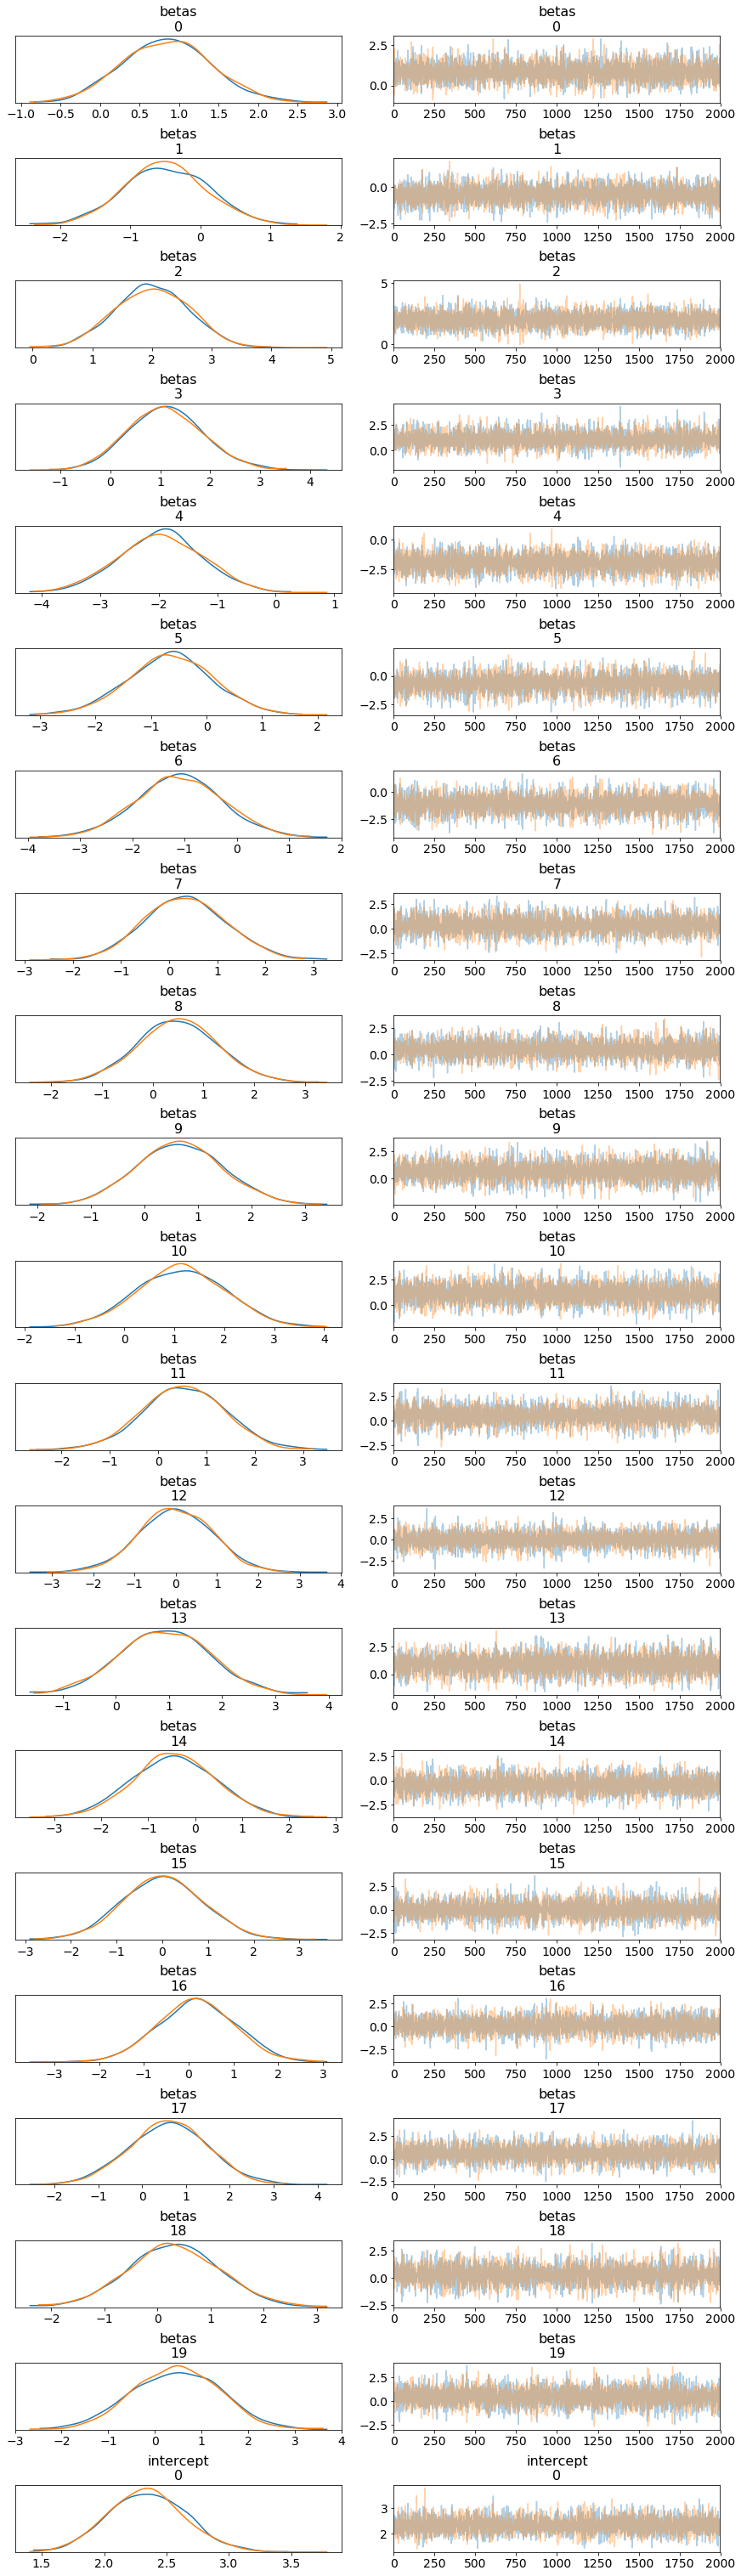

In [131]:
%matplotlib inline 
pm.traceplot(bclsfr.trace);


In [187]:
baybetas =pm.find_MAP(model=bay)["beta"]


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -61.572, ||grad|| = 0.92708: 100%|██████████| 205/205 [00:00<00:00, 1236.96it/s] 


In [62]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
betas =df_trace.mean(0)[1:21]
#intercept = df_trace.mean(0)[-1]
#pm.find_MAP(model=bay)
#bay.Y_obs

In [17]:
def predict(X,betas,intercept):
    
    v = np.dot(X,betas) + intercept
    return(np.exp(v)/(1+np.exp(v)))

In [65]:
(predict(Xn_test,betas=betas,intercept=0) >= 0.5 )*1 ==y_test.bool

ID
2-S15D     True
3-S05d    False
3-S07d    False
2-S18C    False
1-S09B     True
2-S19A     True
3-S19b     True
1-S10C    False
2-S17A    False
3-S01a    False
1-S07D    False
1-S01C    False
1-S07C    False
1-S06A    False
1-S03B    False
2-S16D     True
3-S14e    False
3-S07a     True
3-S06d    False
3-S07b     True
3-S16c     True
1-S01A    False
1-S04D    False
3-S13d    False
3-S03a    False
1-S11D    False
1-S03D    False
2-S18D     True
2-S13C     True
2-S16A     True
3-S13b    False
3-S04b    False
2-S15F    False
Name: Water, dtype: bool

In [104]:
nobservations =150
covariates = np.random.randn(nobservations, 20)
covariates = np.hstack((np.ones((nobservations, 1)), covariates))

true_coefficients = 5 * np.random.rand(21)
true_logits = np.dot(covariates, true_coefficients) 
true_probs = 1.0 / (1.0 + np.exp(-true_logits))
observed_labels = (np.random.rand(nobservations) < true_probs).astype(np.int32)

In [8]:
covariates=Xn_train
covariates = np.hstack((np.ones((Xn_train.shape[0], 1)), covariates))
testset = np.hstack((np.ones((Xn_test.shape[0], 1)), Xn_test))
observed_labels = y_train.bool#(wwfdf.Water =="White")*1

In [10]:
testlog = LogisticRegression(penalty="l2",multi_class="ovr",solver= "saga",max_iter=100000,fit_intercept=False)
testlog.fit(covariates,observed_labels)
#plt.scatter(true_coefficients, testlog.coef_[0, :])
print(testlog.coef_)
#plt.show()
testlog.score(testset,y_test.bool)

[[ 2.12872457e+00  6.83251933e-01 -4.23743952e-01  1.91892137e+00
   9.39033023e-01 -1.89970326e+00 -6.29311823e-01 -1.07495353e+00
   3.09311744e-01  4.70658516e-01  6.24427100e-01  1.08507567e+00
   5.22415752e-01  2.11510231e-02  8.71823982e-01 -4.42129982e-01
  -1.55901587e-03  1.24958881e-01  5.69172029e-01  2.84463900e-01
   4.17924016e-01]]


1.0

In [15]:
nn = 20000
with pm.Model() as testmodel:
    # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
    beta = pm.Normal('beta', 0.0, sd=3.0, shape=20)
    intercept = pm.Normal("inter",0,sd=3,shape=1)
    likelihood = pm.Bernoulli('likelihood', logit_p= tt.dot(Xn_train,beta)+intercept , observed=observed_labels)
    tracetest =pm.sample(nn,step=pm.NUTS(),random_seed=11235)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [inter, beta]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:50<00:00, 819.76draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff89c03ee10>,
      dtype=object)

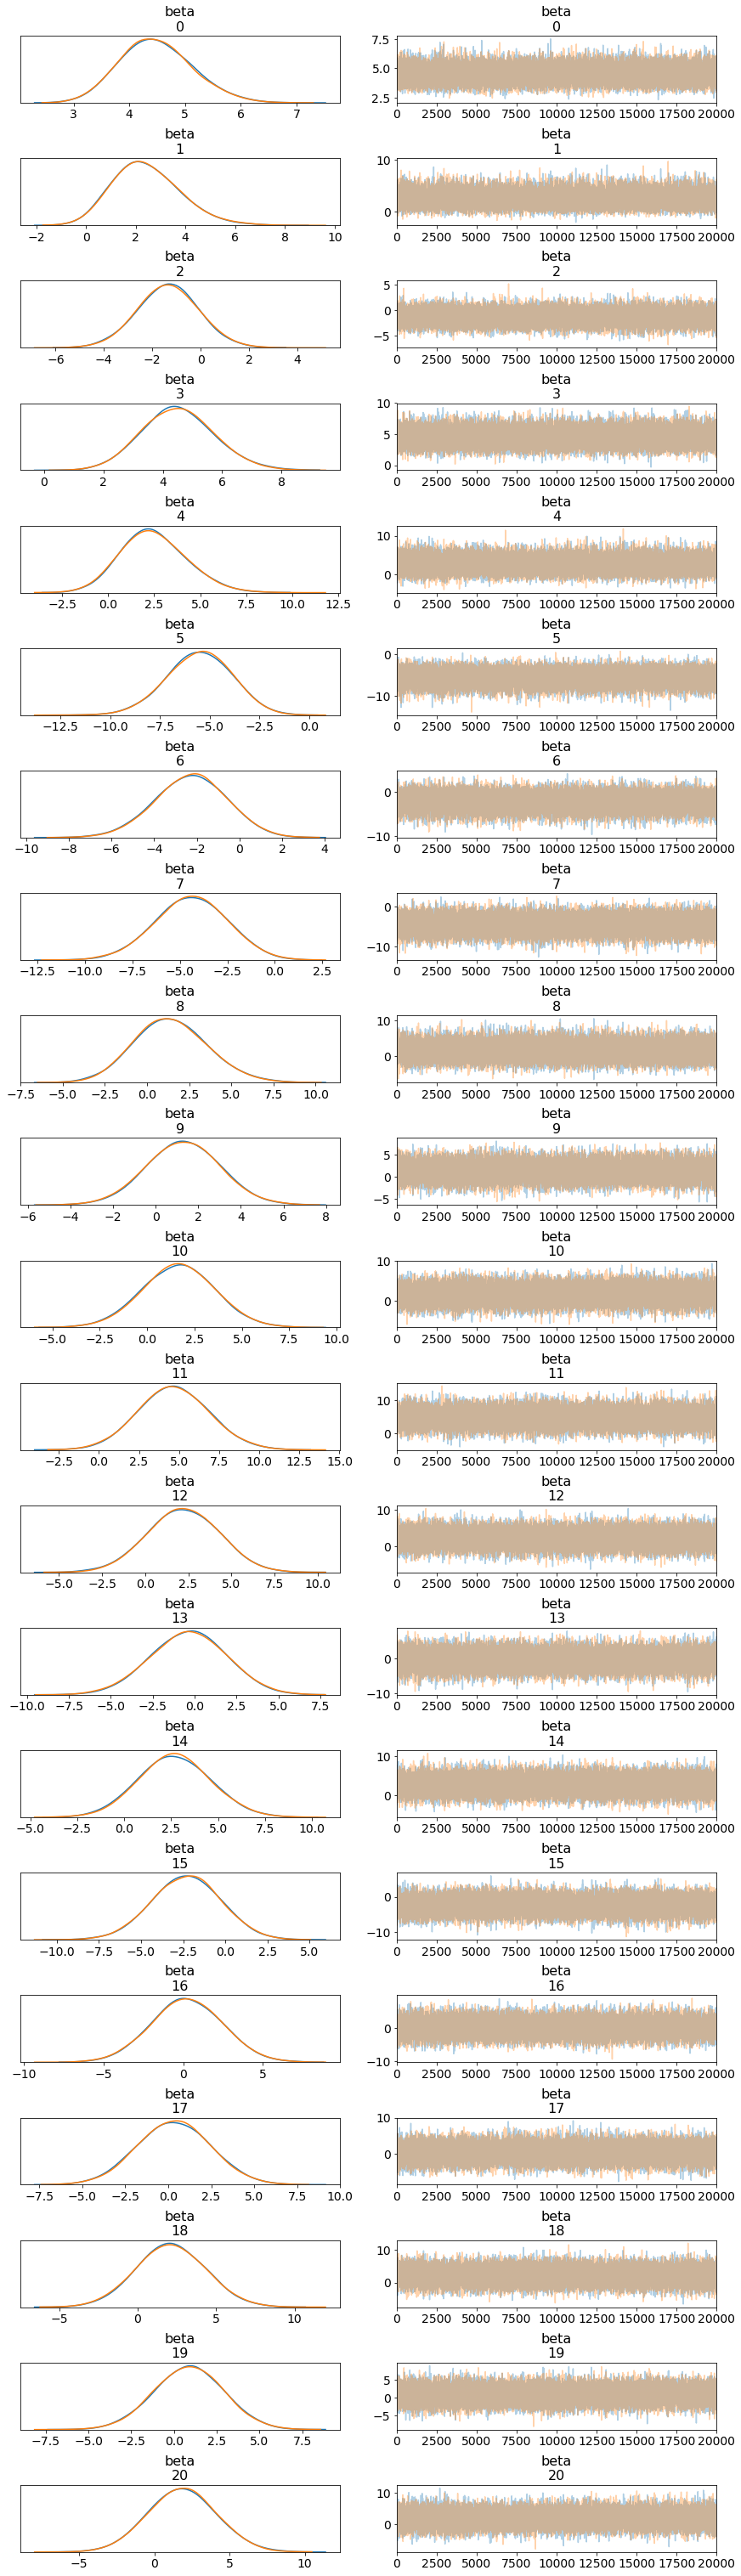

In [12]:
%matplotlib inline
pm.traceplot(tracetest)

In [28]:
maptest = (pm.find_MAP(model=testmodel))
maptest_beta = maptest["beta"]
maptest_inter = maptest["inter"]
#print(true_coefficients)
#plt.scatter(true_coefficients,maptest)

/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -60.543, ||grad|| = 0.00079067: 100%|██████████| 25/25 [00:00<00:00, 848.63it/s]  


In [141]:
# pred_probs =predict(testset,baybetas,0) >=0.5
# print((y_test.bool == pred_probs).mean())
pred_probs =predict(Xn_test,maptest_beta,maptest_inter) >=0.5
(y_test.bool == pred_probs).mean()

0.9696969696969697

# Random Forrest

In [ ]:
def log_cv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    gsc = GridSearchCV(
        estimator=LogisticRegression(penalty="l1",solver='liblinear',max_iter=1000,random_state=11235,fit_intercept=True),
        param_grid={
            'C': np.arange(0.001,20,1)
            #,'fit_intercept': (True)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result

In [46]:
def rfr_cv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (500, 1000,2000,3000),
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=2,refit = "accuracy",return_train_score = False)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
# Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result

In [51]:
bestpar,grid =rfr_cv(X_train,y_train,None)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.6s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  1.0min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


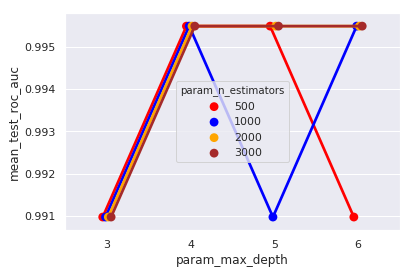

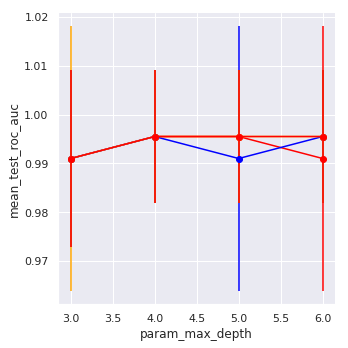

In [357]:
%matplotlib inline
sns.set()
gridpd =pd.DataFrame(grid.cv_results_)
#gridpd.columns
sns.pointplot(x="param_max_depth",y= "mean_test_roc_auc", palette=["red","blue","orange","brown"],hue="param_n_estimators",
             data=gridpd,dodge = True,ci ="sd")
#plt.ylim(0.987,1.001)
#plt.errorbar(data=gridpd,x = "param_max_depth",y= "mean_test_roc_auc",yerr="std_test_roc_auc")
g = sns.FacetGrid(gridpd, palette=["red","blue","orange"],hue="param_n_estimators"
, size=5)
g.map(plt.errorbar, "param_max_depth","mean_test_roc_auc", "std_test_roc_auc", marker="o")

In [213]:
rfr =RandomForestClassifier(max_depth=None, n_estimators=10000,random_state=True, verbose=True)
rfr.fit(X_train,y_train)
rfr.score(X_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.9s finished


0.9393939393939394

Random forest with 10000 trees, max depth set to None and random_state set to True produces an accuracy of 93%, which is equivalent to that of the logistic regression with the saga solver.

In [215]:
rfr.fit(Xn_train,y_train)
rfr.score(Xn_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.7s finished


0.9696969696969697

Using the nmds axis we get an accuracy of 96.7% (which is a single mistake!)

In [204]:
sum(rfr.predict(X_test) == y_test)/y_test.size

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


0.9090909090909091

In [274]:
crossrfr =cross_val_score(rfr,otudf,y=wwfdf.Water,cv=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurren